In [8]:
%pip install --quiet pydantic
from pathlib import Path
import json

product_path = Path("../initial-training-sets/datasets/dataset_products.json")
product_images_path = Path("../initial-training-sets/datasets/images/")
product_data = json.loads(product_path.read_text())

from datetime import date
from uuid import UUID
from pydantic import BaseModel
from typing import List

class RawReview(BaseModel):
    id: UUID
    review_ref: str
    product_id: UUID
    review_content: str
    review_title: str
    date_written: date
    product_asin: str
    helpful_count: int
    rating_given: int
    review_page_url: str

class RAWProduct(BaseModel):
    id: UUID
    name: str
    description: str
    product_asin: str
    overall_ratings: float
    total_customers_that_rated: int
    price: float
    currency: str
    category: str
    sub_category: str
    product_page_url: str
    image_url: str
    reviews: List[RawReview]
    


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Convert Image to Base64

In [9]:
import base64

def encode_image(image_path: str):
    """Returns the base64 string for the image"""
    
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

### Function to trigger the image summary

In [47]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_community.chat_models import ChatOllama

def describe_image(img_base64, prompt, model_name: str, image_format: str = "png"):
        
    
    """
    Describes the image provided. The prompt is used to guide the model on what
    to do with the description and what it should do.

    Raises:
        ValueError: If the wrong model name is provided.
        Exception: If any error occur

    Returns:
        str: The description generated for the image
    """
    
    if model_name not in [ "llava", "gpt-4o" ]:
        raise ValueError("Please provide either llava or gpt-4o")
    
    image_url = f"data:image/{image_format};base64,{img_base64}"
    
    if model_name == "gpt-4o":
        chat = ChatOpenAI(model=model_name, max_tokens=1024)
        msg = chat.invoke([
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_url
                        }
                    }
                ]
            )
        ])
    elif model_name == "llava":
        chat = ChatOllama(model=model_name, num_ctx=1024)
        msg = chat.invoke([
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_url
                        }
                    }
                ]
            )
        ])
    else:
        raise Exception("Unknown model name.")
        
    return msg.content

In [98]:
product = product_data['MEN_FASHION_WITH_REVIEWS']['products'][3]
image_path = f"{product_images_path}/{product['product_asin']}.png"
img_base64 = encode_image(image_path)

image_prompt = f"""
Describe and summarise the characteristics of the product you are looking at. Return back plain text no markdown.
"""

# image_prompt = f"""
# To give you context, here is the description of the product:

# {product['description']}"""


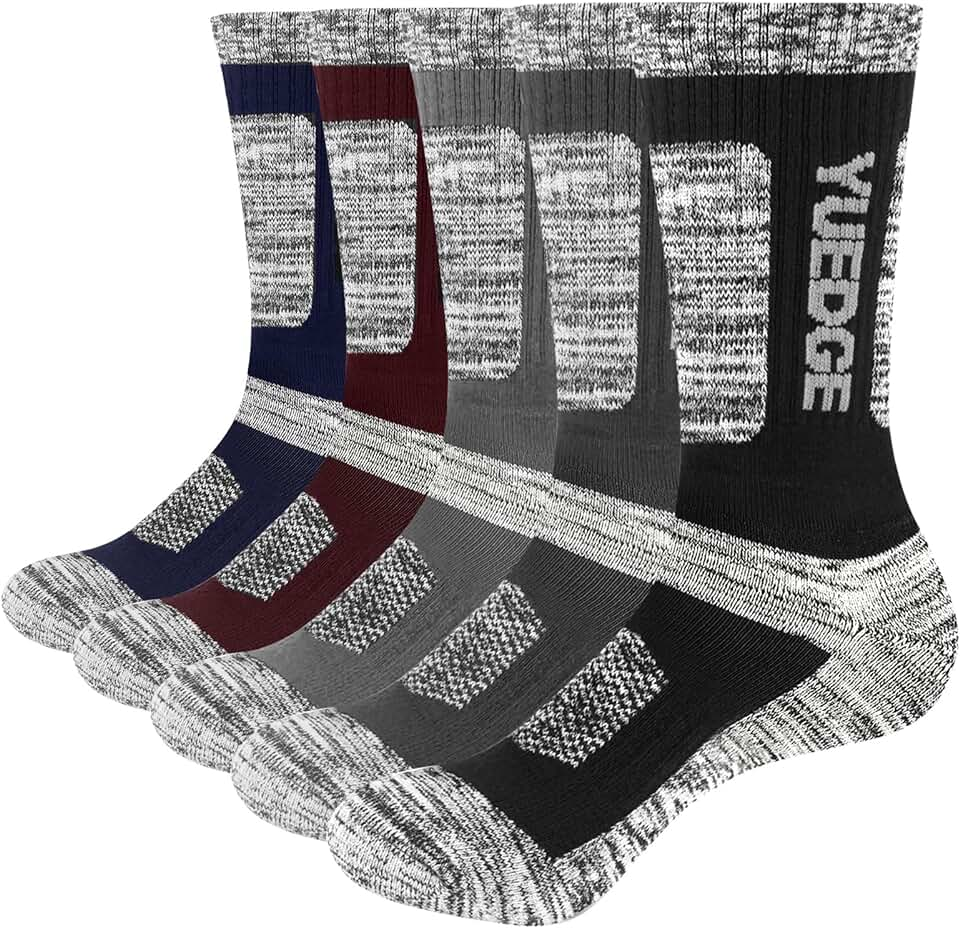

In [99]:
from PIL import Image
from IPython.display import HTML, display

def plt_img_base64(img_base64):
  """Display base64 encoded string as image"""

  # Create an HTML img tag with the base64 string as the source
  image_html = f'<img width="200px" height="200px" src="data:image/jpeg;base64,{img_base64}" />'
  display(HTML(image_html))
  
plt_img_base64(img_base64)

### Using llava

In [100]:
description = describe_image(img_base64, prompt=image_prompt, model_name="llava")
print(description)

 The image shows a display of four pairs of socks, arranged side by side. Each pair has the brand "Vudege" visible on them. The socks are presented in what appears to be a retail or promotional setting. The socks come in various colors and patterns; two have a textured appearance, one is plain black with white lettering, and the last one has multiple colors including black, red, blue, and white. They are displayed against a backdrop that is not clearly visible due to the image's resolution. There are no visible texts other than the brand name on the socks themselves. 


### Using GPT-4o

In [101]:
img_base64 = encode_image(image_path)
description = describe_image(img_base64, prompt=image_prompt, model_name="gpt-4o")
print(description)

The product is a set of socks branded as YUEDGE. They feature a ribbed design with a combination of solid and heathered patterns. There are five pairs of socks in this set, each with different color accents: navy blue, burgundy, grey, and black. The socks have reinforced toe and heel areas, providing additional durability. They are designed with a high calf length and appear to be suitable for outdoor or athletic use. The YUEDGE logo is prominently displayed on the side of the socks.


PosixPath('/home/solomon/Documents/projects/ciam2rag/ciam2rag_core/notebooks/../initial-training-sets/datasets/images/B07BSZXWWT.png')